In [1]:
from qiskit import *
from qiskit.tools.visualization import *
from qiskit.test.mock import FakeVigo
from qiskit.tools.monitor import job_monitor
from qiskit import QuantumCircuit, execute, Aer
from qiskit.visualization import plot_histogram
from qiskit.providers.aer import AerSimulator
import matplotlib.pyplot as plt
import math
import numpy as np
import qiskit.providers.aer.noise as noise


#from qiskit.ignis.mitigation.measurement import *
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal, 
                                                 CompleteMeasFitter, TensoredMeasFitter)

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Check the version of qiskit
import qiskit.tools.jupyter
%qiskit_version_table

In [3]:
#Neccissary statements for running on a real machine
from qiskit import IBMQ
IBMQ.save_account("Token")
IBMQ.load_account()

configrc.store_credentials:WARNING:2021-06-11 11:14:57,681: Credentials already present. Set overwrite=True to overwrite.


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [4]:
#Uncomment this and comment out the below statements if you want to run only simulations.
#backend = Aer.get_backend('qasm_simulator')

#Tells qiskit to run on a real machine
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_santiago')

properties = backend.properties()

# Mixed Field Ising Model (Open Boundary) via Trotter Circuit

The Hamiltonian we consider 

$H=V\sum_{i}^{L-1}Z_{i}Z_{i+1}+\Omega\sum_{i}^{L}X_{i}+h\sum_{i}^{L}Z_{i}$

In [5]:
def h_Z(qc,h,dt):
    
    for i in range(5):
        
        qc.rz(2*h*dt,i)
        
def X_Rabi(qc,Omega,dt): # Rabi coupling
    
    for i in range(5):
        
        qc.rx(2*Omega*dt,i)
        
def ZZ(qc,V,dt): # nearest neighbor coupling
    
    qc.cx(0,1)
    
    qc.rz(-2*V*dt,1)
    
    qc.cx(0,1)
    
    qc.cx(2,3)
    
    qc.rz(-2*V*dt,3)
    
    qc.cx(2,3)
    
    qc.cx(1,2)
    
    qc.rz(-2*V*dt,2)
    
    qc.cx(1,2)
    
    qc.cx(3,4)
    
    qc.rz(-2*V*dt,4)
    
    qc.cx(3,4)
    

In [6]:
def Trotter_circuit_5_site(h,Omega,V,T,n):
    
    Trotter_circuits = []
    
    dt=T/n
    
    for i in range(n):
        
        Trotter_circuit = QuantumCircuit(5)
        
        ### Initial state setting
        
        Trotter_circuit.x(1)
        
        Trotter_circuit.x(3)
        
        ###
        
        Trotter_circuit.barrier()
        
        for k in range(i):
            X_Rabi(Trotter_circuit,Omega,dt) # Rabi coupling from the second term of Hamiltonian
            
            h_Z(Trotter_circuit,h,dt) # Z field 
            
            ZZ(Trotter_circuit,V,dt) # Nearest neighbor hopping term
            
            Trotter_circuit.barrier()
            
        Trotter_circuit.measure_all()
        
        Trotter_circuits.append(Trotter_circuit)
        
    return Trotter_circuits
    
    

In [7]:
Omega = 0.2*2

h = 2*2

V = 1*2

T = 10 # Total time

TT=T

n = 20

NN=n

#builds the actual circuit
Trotter_circuit = Trotter_circuit_5_site(h,Omega,V,T,n)

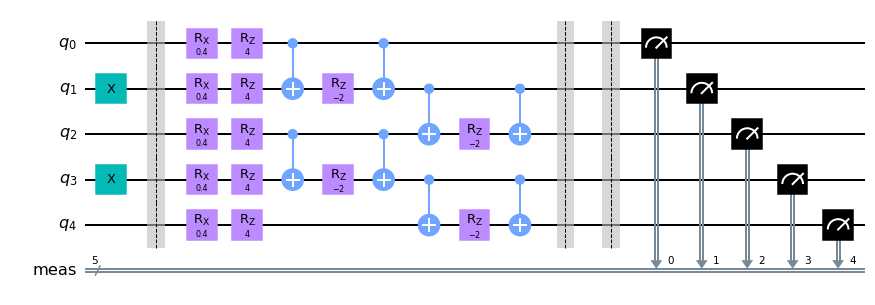

In [8]:
#Draw the circuit at t=1. Note that Trotter_circuit is a list.
Trotter_circuit[1].draw(output = "mpl") # One time step illustration

In [9]:
qr = QuantumRegister(5)

qubit_list = [0,1,2,3,4]

meas_calibs, state_labels = complete_meas_cal(qubit_list=qubit_list, qr=qr, circlabel='mcal')


In [10]:
#How many shots the circuit takes
shots = 8192

il = [0,1,2,3,4] #initial layout

Trotter_circuit_sim = execute(Trotter_circuit, Aer.get_backend('qasm_simulator'), 
                              shots=shots, initial_layout=il) #Simulation data

#Real Machine data, no mitigation
Trotter_result = execute(Trotter_circuit, backend, shots=shots, initial_layout=il)

#Real Machine data, with mitigation
Trotter_mit  = execute(meas_calibs, backend, shots=shots, initial_layout=il)

In [11]:
job_monitor(Trotter_result)


Job Status: job has successfully run


In [12]:
#error mitigated counts
result_counts = Trotter_mit.result()

#get useful values out of Trotter_result
results = Trotter_result.result()

In [13]:
cal_results = Trotter_mit.result()

#This is needed for the code to run correctly. Not sure why
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')

#this is DIFFERENT from meas_fitter
meas_filter = meas_fitter.filter

In [14]:
#get the expectation values of Z for each qubit for the error mitigated and non-error mitigated data
# on the real machine
Sz_nomit = []
Sz_mit = []
for i in range(NN):
    tot_nomit=np.zeros(5)
    tot_mit=np.zeros(5)
    Result_nomit = results.get_counts(i) 
    mitigated_counts = meas_fitter.filter.apply(results).get_counts(i)
    for j in range(2**5):
        n=2**5
        if j in Result_nomit.int_outcomes():
            a=bin(n+j)[3:]
            c= ' '
            tot_nomit+=(2*np.array(c.join(a).split()).astype(int)-1)*Result_nomit.int_outcomes()[j] 
        if j in mitigated_counts.int_outcomes():
            a=bin(n+j)[3:]
            c= ' '
            tot_mit+=(2*np.array(c.join(a).split()).astype(int)-1)*mitigated_counts.int_outcomes()[j]
    Sz_nomit.append(tot_nomit/shots)
    Sz_mit.append(tot_mit/shots)
Sz_nomit=np.array(Sz_nomit)
Sz_mit=np.array(Sz_mit)

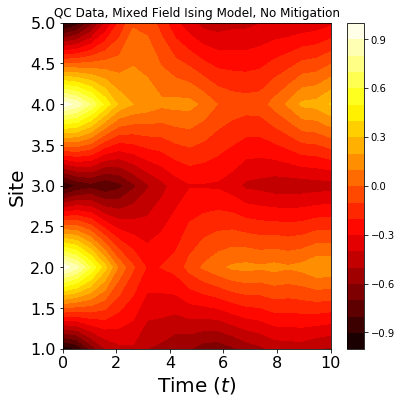

In [15]:
#plot the results using a contour plot

t=np.linspace(0,TT,NN)
l=np.linspace(1,5,5)
tt, ll = np.meshgrid(t, l)

fig, ax = plt.subplots(figsize=(6,6))
cg=ax.contourf(tt, ll, np.transpose(Sz_nomit), 20, vmin=-1, vmax=1, cmap='hot')
fig.colorbar(cg, ax=ax)

ax.set_ylabel('Site', fontsize =20)
ax.set_xlabel('Time $(t)$', fontsize =20)

plt.title('QC Data, Mixed Field Ising Model, No Mitigation')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()


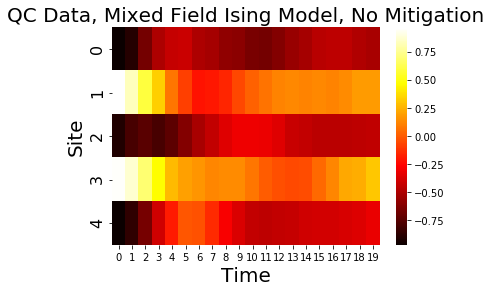

In [16]:
#alternative plot

import numpy as np
#import cv2

import seaborn as sns
#boulder_monthly_precip = [i+1 for i in range(180)]
#months = [(i+1)/4 for i in range(180)]

ax = sns.heatmap(np.transpose(Sz_nomit), cmap="hot")

ax.set_xlabel('Time', fontsize =20)
ax.set_ylabel('Site', fontsize =20)

plt.title('QC Data, Mixed Field Ising Model, No Mitigation', fontsize=20)
plt.xticks(fontsize=10)
plt.yticks(fontsize=16)
plt.show()

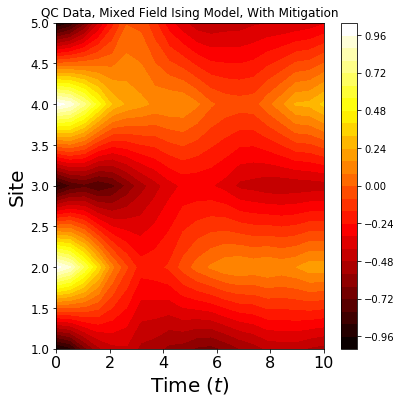

In [17]:
#Plot the results of the error mitigated run

t=np.linspace(0,TT,NN)
l=np.linspace(1,5,5)
tt, ll = np.meshgrid(t, l)

fig, ax = plt.subplots(figsize=(6,6))
cg=ax.contourf(tt, ll, np.transpose(Sz_mit), 30, vmin=-1, vmax=1, cmap='hot')
#ax = sns.heatmap(np.transpose(Sz_mit), cbar=0, cmap='hot')
fig.colorbar(cg, ax=ax)

ax.set_ylabel('Site', fontsize =20)
ax.set_xlabel('Time $(t)$', fontsize =20)

plt.title('QC Data, Mixed Field Ising Model, With Mitigation')
plt.xticks(fontsize=16)
plt.yticks(fontsize=12)
plt.show()

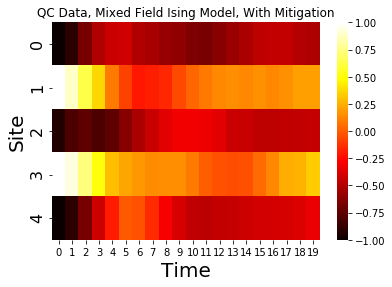

In [18]:
#alternate plot

import numpy as np

import seaborn as sns

ax = sns.heatmap(np.transpose(Sz_mit), cmap="hot")

ax.set_xlabel('Time', fontsize =20)
ax.set_ylabel('Site', fontsize =20)

plt.title('QC Data, Mixed Field Ising Model, With Mitigation')
plt.xticks(fontsize=10)
plt.yticks(fontsize=16)
plt.show()

In [19]:
#Same model, but simulated this time

result_sim=Trotter_circuit_sim.result()

In [20]:
#Get Z expectation value
Sz_sim = []
for i in range(NN):
    tot_sim=np.zeros(5)
    Result_sim = result_sim.get_counts(i) 
    for j in range(2**5):
        n=2**5
        if j in Result_sim.int_outcomes():
            a=bin(n+j)[3:]
            c= ' '
            tot_sim+=(2*np.array(c.join(a).split()).astype(int)-1)*Result_sim.int_outcomes()[j] 
    Sz_sim.append(tot_sim/8192)
Sz_sim=np.array(Sz_sim)

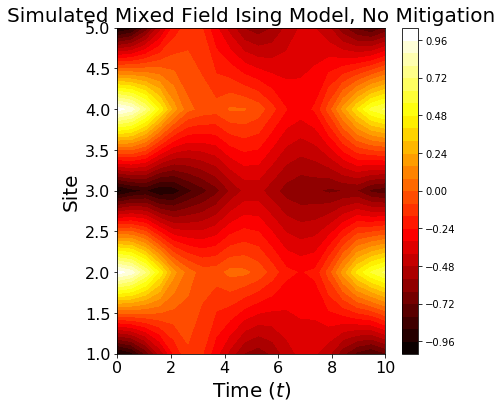

In [21]:
#Plot the simulation
t=np.linspace(0,T,NN)
l=np.linspace(1,5,5)
tt, ll = np.meshgrid(t, l)

fig, ax = plt.subplots(figsize=(6,6))
cg=ax.contourf(tt, ll, np.transpose(Sz_sim), 30, vmin=-1, vmax=1, cmap='hot')
fig.colorbar(cg, ax=ax)

ax.set_ylabel('Site', fontsize =20)
ax.set_xlabel('Time $(t)$', fontsize =20)

plt.title('Simulated Mixed Field Ising Model, No Mitigation', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()

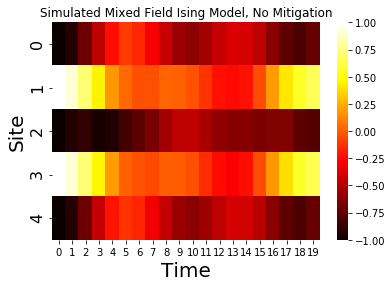

In [22]:
#Alternate simulation plot
import numpy as np

import seaborn as sns

ax = sns.heatmap(np.transpose(Sz_sim), cmap="hot")

ax.set_xlabel('Time', fontsize =20)
ax.set_ylabel('Site', fontsize =20)

plt.title('Simulated Mixed Field Ising Model, No Mitigation')
plt.xticks(fontsize=10)
plt.yticks(fontsize=16)
plt.show()

# Rydberg Blockade (Open Boundary) via Trotter Circuit

The Rydberg Blockade Hamiltonian we consider 

$H=V\sum_{i}^{L-1}n_{i}n_{i+1}+\Omega\sum_{i}^{L}X_{i}$,

where $n_{i}=\frac{\hat{I}+Z_{i}}{2}$.

The Hamiltonian can be expressed in terms of Pauli matrix Z

$H=V\sum_{i}^{L-1}Z_{i}Z_{i+1}+\Omega\sum_{i}^{L}X_{i}+2V\sum_{i=2}^{L-1}Z_{i}+VZ_{1}+VZ_{L}+VL\hat{I}$,

where the last term is identity which is involved in the dynamics so we can discard this term.

$H=V\sum_{i}^{L-1}Z_{i}Z_{i+1}+\Omega\sum_{i}^{L}X_{i}+2V\sum_{i=2}^{L-1}Z_{i}+VZ_{1}+VZ_{L}$.



In [23]:
#Modify the h_Z function so we have the correct model
def h_Z(qc,h,dt):
    for i in range(5):
        if i==0 or i==4:
            qc.rz(h*dt,i)
        else:
            qc.rz(2*h*dt,i)

In [24]:
Omega = 0.2*2

V = 1*2

T = 10 # Total time 

TT=T

n = 20

NN=n

Trotter_circuit = Trotter_circuit_5_site(2*V,Omega,V,T,n)

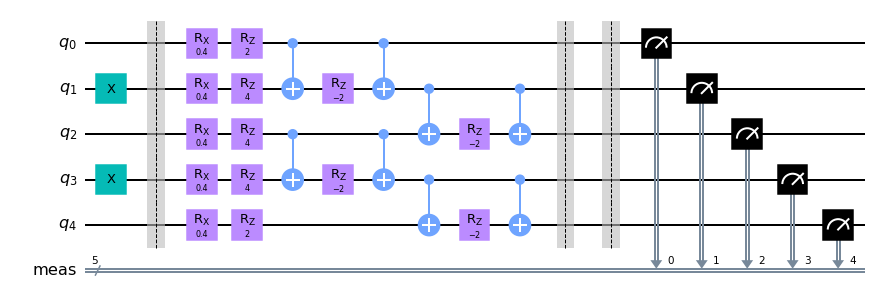

In [25]:
Trotter_circuit[1].draw(output = "mpl")

In [26]:
qr = QuantumRegister(5)

qubit_list = [0,1,2,3,4]

meas_calibs, state_labels = complete_meas_cal(qubit_list=qubit_list, qr=qr, circlabel='mcal')

In [27]:
shots = 8192

#Initial Layout
il = [0,1,2,3,4]

#simulated results
Trotter_circuit_sim = execute(Trotter_circuit, Aer.get_backend('qasm_simulator'), 
                              shots=shots, initial_layout=il)

#Actual machine results
Trotter_result = execute(Trotter_circuit, backend, shots=shots, initial_layout=il)

#Actual machine results with measurement error mitigation
Trotter_mit  = execute(meas_calibs, backend, shots=shots, initial_layout=il)

In [28]:
job_monitor(Trotter_result)

Job Status: job has successfully run


In [29]:
result_counts = Trotter_mit.result()

results = Trotter_result.result()

In [30]:
cal_results = Trotter_mit.result()

meas_fitter = CompleteMeasFitter(cal_results, state_labels, qubit_list=qubit_list, circlabel='mcal')

In [31]:
#Get the expectation value of Z out from the data generated by the real machine
Sz_nomit = []
Sz_mit = []
for i in range(NN):
    tot_nomit=np.zeros(5)
    tot_mit=np.zeros(5)
    Result_nomit = results.get_counts(i) 
    mitigated_counts = meas_fitter.filter.apply(results).get_counts(i)
    for j in range(2**5):
        n=2**5
        if j in Result_nomit.int_outcomes():
            a=bin(n+j)[3:]
            c= ' '
            tot_nomit+=(2*np.array(c.join(a).split()).astype(int)-1)*Result_nomit.int_outcomes()[j] 
        if j in mitigated_counts.int_outcomes():
            a=bin(n+j)[3:]
            c= ' '
            tot_mit+=(2*np.array(c.join(a).split()).astype(int)-1)*mitigated_counts.int_outcomes()[j]
    Sz_nomit.append(tot_nomit/shots)
    Sz_mit.append(tot_mit/shots)
Sz_nomit=np.array(Sz_nomit)
Sz_mit=np.array(Sz_mit)

In [32]:
#print('Sz_nomit = \n', Sz_nomit)

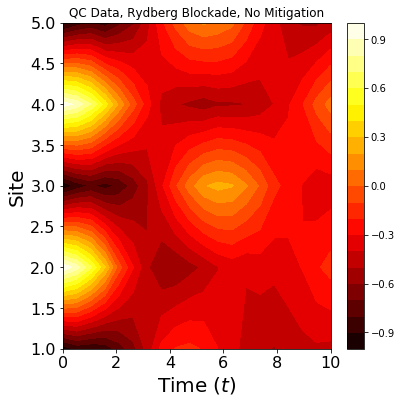

In [33]:
#Plot the real machine data
t=np.linspace(0,TT,NN)
l=np.linspace(1,5,5)
tt, ll = np.meshgrid(t, l)

fig, ax = plt.subplots(figsize=(6,6))
cg=ax.contourf(tt, ll, np.transpose(Sz_nomit), 20, vmin=-1, vmax=1, cmap='hot')
fig.colorbar(cg, ax=ax)

ax.set_ylabel('Site', fontsize =20)
ax.set_xlabel('Time $(t)$', fontsize =20)

plt.title('QC Data, Rydberg Blockade, No Mitigation')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()

In [34]:
#Get the data for each qubit individually
q0_nomit_list = []
q1_nomit_list = []
q2_nomit_list = []
q3_nomit_list = []
q4_nomit_list = []

for x in range(0,len(Sz_nomit)):
    q0_nomit_list.append(Sz_nomit[x,0])
    q1_nomit_list.append(Sz_nomit[x,1])
    q2_nomit_list.append(Sz_nomit[x,2])
    q3_nomit_list.append(Sz_nomit[x,3])
    q4_nomit_list.append(Sz_nomit[x,4])

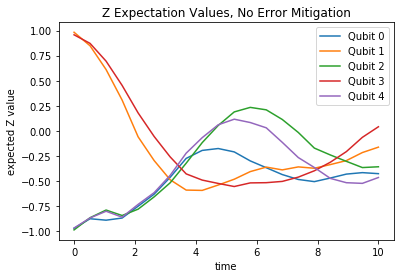

In [35]:
#Plot the expected Z value as a function of time for each qubit
fig,ax = plt.subplots()
ax.plot(t, q0_nomit_list, label='Qubit 0')
ax.plot(t, q1_nomit_list, label='Qubit 1')
ax.plot(t, q2_nomit_list, label='Qubit 2')
ax.plot(t, q3_nomit_list, label='Qubit 3')
ax.plot(t, q4_nomit_list, label='Qubit 4')
ax.set_xlabel('time')
ax.set_ylabel('expected Z value')
ax.set_title("Z Expectation Values, No Error Mitigation")
ax.legend()

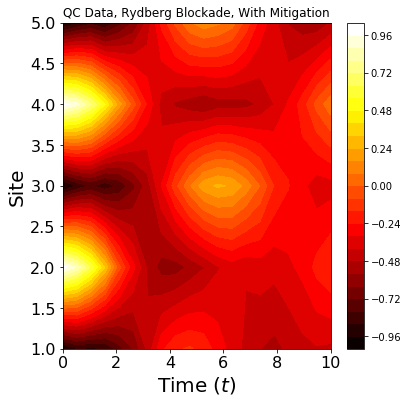

In [36]:
#Error mitigated data from the real machine
t=np.linspace(0,TT,NN)
l=np.linspace(1,5,5)
tt, ll = np.meshgrid(t, l)

fig, ax = plt.subplots(figsize=(6,6))
cg=ax.contourf(tt, ll, np.transpose(Sz_mit), 30, vmin=-1, vmax=1, cmap='hot')

fig.colorbar(cg, ax=ax)

ax.set_ylabel('Site', fontsize =20)
ax.set_xlabel('Time $(t)$', fontsize =20)

plt.title('QC Data, Rydberg Blockade, With Mitigation')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

In [37]:
#Error mitigated expectation values for each qubit
q0_mit_list = []
q1_mit_list = []
q2_mit_list = []
q3_mit_list = []
q4_mit_list = []

for x in range(0,len(Sz_mit)):
    q0_mit_list.append(Sz_mit[x,0])
    q1_mit_list.append(Sz_mit[x,1])
    q2_mit_list.append(Sz_mit[x,2])
    q3_mit_list.append(Sz_mit[x,3])
    q4_mit_list.append(Sz_mit[x,4])

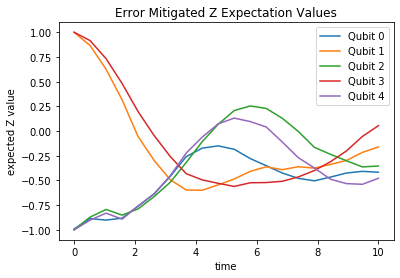

In [38]:
#plot error mitigated Z expectation values
fig,ax = plt.subplots()
ax.plot(t, q0_mit_list, label='Qubit 0')
ax.plot(t, q1_mit_list, label='Qubit 1')
ax.plot(t, q2_mit_list, label='Qubit 2')
ax.plot(t, q3_mit_list, label='Qubit 3')
ax.plot(t, q4_mit_list, label='Qubit 4')
ax.set_xlabel('time')
ax.set_ylabel('expected Z value')
ax.set_title("Error Mitigated Z Expectation Values")
ax.legend()

In [39]:
result_sim=Trotter_circuit_sim.result()

In [40]:
#Get the simulated Z expectation values from the circuit
Sz_sim = []
for i in range(NN):
    tot_sim=np.zeros(5)
    Result_sim = result_sim.get_counts(i) 
    for j in range(2**5):
        n=2**5
        if j in Result_sim.int_outcomes():
            a=bin(n+j)[3:]
            c= ' '
            tot_sim+=(2*np.array(c.join(a).split()).astype(int)-1)*Result_sim.int_outcomes()[j] 
    Sz_sim.append(tot_sim/shots)
Sz_sim=np.array(Sz_sim)

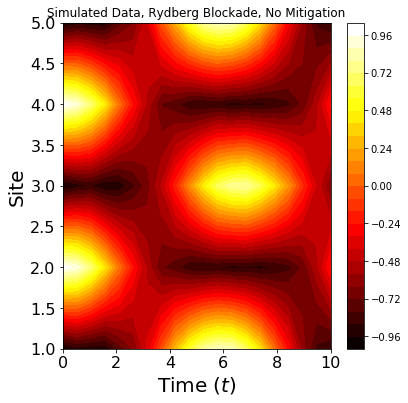

In [41]:
#Plot the simulated data
t=np.linspace(0,T,NN)
l=np.linspace(1,5,5)
tt, ll = np.meshgrid(t, l)

fig, ax = plt.subplots(figsize=(6,6))
cg=ax.contourf(tt, ll, np.transpose(Sz_sim), 30, vmin=-1, vmax=1, cmap='hot')
fig.colorbar(cg, ax=ax)

ax.set_ylabel('Site', fontsize =20)
ax.set_xlabel('Time $(t)$', fontsize =20)

plt.title('Simulated Data, Rydberg Blockade, No Mitigation')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()

In [42]:
#Get data from each qubit
q0_sim_list = []
q1_sim_list = []
q2_sim_list = []
q3_sim_list = []
q4_sim_list = []

for x in range(0,len(Sz_sim)):
    q0_sim_list.append(Sz_sim[x,0])
    q1_sim_list.append(Sz_sim[x,1])
    q2_sim_list.append(Sz_sim[x,2])
    q3_sim_list.append(Sz_sim[x,3])
    q4_sim_list.append(Sz_sim[x,4])

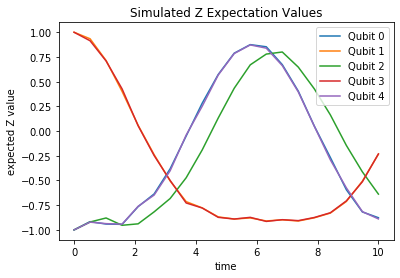

In [43]:
#Plot individual qubit results
fig,ax = plt.subplots()
ax.plot(t, q0_sim_list, label='Qubit 0')
ax.plot(t, q1_sim_list, label='Qubit 1')
ax.plot(t, q2_sim_list, label='Qubit 2')
ax.plot(t, q3_sim_list, label='Qubit 3')
ax.plot(t, q4_sim_list, label='Qubit 4')
ax.set_xlabel('time')
ax.set_ylabel('expected Z value')
ax.set_title("Simulated Z Expectation Values")
ax.legend()

# Classical simulation (Exact Diagonalization)

In [44]:
import scipy.linalg as la

def flip(n,i,L): 
    # Flip the i site spin in n-state with system size L
    ii=2**(L-i-1)
    nn=2**L
    if int(bin(n+nn)[3:][i])==1:
        return binaryToDecimal(int(bin(n-ii)[2:]))
    if int(bin(n+nn)[3:][i])==0:
        return binaryToDecimal(int(bin(n+ii)[2:]))


def binaryToDecimal(binary): 
    # change the binary number into decimal number
    binary1 = binary 
    decimal, i, n = 0, 0, 0
    while(binary != 0): 
        dec = binary % 10
        decimal = decimal + dec * pow(2, i) 
        binary = binary//10
        i += 1
    return decimal  

def spin_x(i,L): # i site Pauli matrix x on the spin chain with system size L  
    n=2**L
    X=np.zeros((n,n))
    for j in range(n):
        X[j,flip(j,i,L)]=1
    return X

def spin_y(i,L): # i site Pauli matrix y on the spin chain with system size L  
    n=2**L
    Y=np.zeros((n,n),dtype=complex)
    for j in range(n):
        Y[j,flip(j,i,L)]=1j*(-1)**(int(bin(j+n)[3:][i]))
    return Y

def spin_z(i,L): # i site Pauli matrix z on the spin chain with system size L  
    n=2**L
    Z=np.zeros((n,n))
    #a=2**L-1
    for j in range(n):
        Z[j,j]=2*int(bin(j+n)[2:][::-1][i])-1
    return Z



In [45]:
L=5
HN=2**5

Omega=0.2*2
h=2*2 #2*2
V=1*2

H0=0
for i in range(L):
    H0=H0+Omega*spin_x(i,L) # Rabi coupling
    
H1=0
H1=H1+h*spin_z(0,L)/2
H1=H1+h*spin_z(L-1,L)/2
for i in range(L-2):
    H1=H1+h*spin_z(i+1,L) 


V0=0
for i in range(L-1): # Nearest neighbor coupling
    n_f=spin_z((i)%L,L)
    n_b=spin_z((i+1)%L,L)
    V0=V0+V*np.dot(n_f,n_b)


H=H0+H1+V0

In [46]:
M=H
vals, vecs = la.eigh(M)

inds=np.argsort(vals)

e=vals[inds]

v=vecs[:,inds]

In [47]:
Nt=20-1
T=5
dt=T/Nt

A=np.eye(len(e))*e
U=np.dot(v,np.dot(np.exp(-1j*A*dt)*np.eye(len(e)),np.conj(np.transpose(v))))

# set up initial state 
f = 10

wavefunc=np.zeros((len(e),Nt+1),dtype=complex)
n=np.zeros(len(e),dtype=complex)

n[f]=1
wavefunc[:,0]=n
for i in range(Nt):
    wavefunc[:,i+1]=np.dot(U,wavefunc[:,i])


In [48]:
def Zi_t_p(tf,dt,f,i):
  
  
    Nt=tf/dt
    Nt=int(Nt)

    Zt=spin_z(i,L)
    Zt1=[np.real(np.dot(np.conjugate(wavefunc[:,i]),np.dot(Zt,wavefunc[:,i]))) for i in range(Nt+1)]
    Zt1=np.stack(Zt1,axis=0)
    
    return Zt1

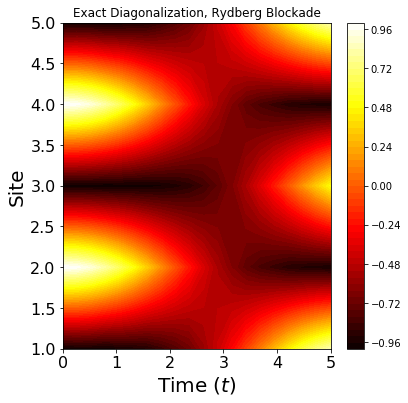

In [49]:
Zi=np.zeros((L,Nt+1))
for i in range(L):
    Zi[i,:]=np.real(Zi_t_p(T,dt,f,i))
t=np.linspace(0,T,Nt+1)
l=np.linspace(1,L,L)
T, LL = np.meshgrid(t, l)

fig, ax = plt.subplots(figsize=(6,6))
cg=ax.contourf(T, LL, Zi, 50, vmin=-1, vmax=1, cmap='hot')
fig.colorbar(cg, ax=ax)

ax.set_ylabel('Site', fontsize =20)
ax.set_xlabel('Time $(t)$', fontsize =20)

plt.title('Exact Diagonalization, Rydberg Blockade')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()

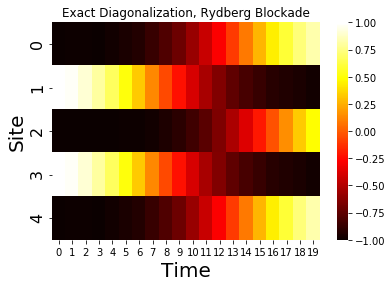

In [50]:
import numpy as np

import seaborn as sns

ax = sns.heatmap(Zi, cmap="hot")

ax.set_xlabel('Time', fontsize =20)
ax.set_ylabel('Site', fontsize =20)

plt.title('Exact Diagonalization, Rydberg Blockade')
plt.xticks(fontsize=10)
plt.yticks(fontsize=16)
plt.show()

Rydberg Blockade With Noise Modeling:

In [51]:
# Error probabilities
prob_1 = 0.001  # 1-qubit gate
prob_2 = 0.05   # 2-qubit gate

# Depolarizing quantum errors
error_1 = noise.depolarizing_error(prob_1, 1)
error_2 = noise.depolarizing_error(prob_2, 2)

# Add errors to noise model
noise_model = noise.NoiseModel()
noise_model.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3'])
noise_model.add_all_qubit_quantum_error(error_2, ['cx'])

# Get basis gates from noise model
basis_gates = noise_model.basis_gates

In [52]:
Omega = 0.2*2

h = 2*2

V = 1*2

T = 10 # Total time

TT=T

n = 20

NN=n


Trotter_circuit = Trotter_circuit_5_site(h,Omega,V,T,n) #Build the circuits

#Run the circuit, with the noise model
Trotter_circuit_sim = execute(Trotter_circuit, Aer.get_backend('qasm_simulator'), basis_gates=basis_gates,
                              noise_model = noise_model, shots=shots, initial_layout=il)

In [53]:
device_backend = FakeVigo()
sim_vigo = AerSimulator.from_backend(device_backend)

#qiskit says it is critical to transpile the circuit!
tcirc = transpile(Trotter_circuit, sim_vigo)

In [54]:
result_sim=Trotter_circuit_sim.result()

result_noise = sim_vigo.run(tcirc).result()

In [55]:
result_sim_noise=Trotter_circuit_sim.result()

#Get the Z expectation values for each qubit in the noise model
Sz_sim_noise = []
for i in range(NN):
    tot_sim=np.zeros(5)
    Result_sim_noise = result_sim_noise.get_counts(i) 
    for j in range(2**5):
        n=2**5
        if j in Result_sim_noise.int_outcomes():
            a=bin(n+j)[3:]
            c= ' '
            tot_sim+=(2*np.array(c.join(a).split()).astype(int)-1)*Result_sim_noise.int_outcomes()[j] 
    Sz_sim_noise.append(tot_sim/shots)
Sz_sim_noise=np.array(Sz_sim_noise)

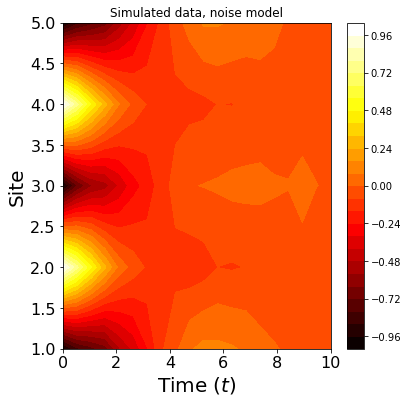

In [56]:
#Countour Plot of the noise model
t=np.linspace(0,T,NN)
l=np.linspace(1,5,5)
tt, ll = np.meshgrid(t, l)

fig, ax = plt.subplots(figsize=(6,6))
cg=ax.contourf(tt, ll, np.transpose(Sz_sim_noise), 30, vmin=-1, vmax=1, cmap='hot')
fig.colorbar(cg, ax=ax)

ax.set_ylabel('Site', fontsize =20)
ax.set_xlabel('Time $(t)$', fontsize =20)

plt.title('Simulated data, noise model')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()

In [57]:
#Individual qubit data
q0_mit_list = []
q1_mit_list = []
q2_mit_list = []
q3_mit_list = []
q4_mit_list = []

for x in range(0,len(Sz_sim_noise)):
    q0_mit_list.append(Sz_sim_noise[x,0])
    q1_mit_list.append(Sz_sim_noise[x,1])
    q2_mit_list.append(Sz_sim_noise[x,2])
    q3_mit_list.append(Sz_sim_noise[x,3])
    q4_mit_list.append(Sz_sim_noise[x,4])

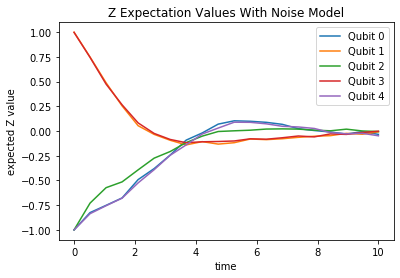

In [58]:
#Plot the individual qubit data
fig,ax = plt.subplots()
ax.plot(t, q0_mit_list, label='Qubit 0')
ax.plot(t, q1_mit_list, label='Qubit 1')
ax.plot(t, q2_mit_list, label='Qubit 2')
ax.plot(t, q3_mit_list, label='Qubit 3')
ax.plot(t, q4_mit_list, label='Qubit 4')
ax.set_xlabel('time')
ax.set_ylabel('expected Z value')
ax.set_title("Z Expectation Values With Noise Model")
ax.legend()